### Import Libraries

This cell imports various libraries needed for data manipulation, visualization, and model building. These include:

- **NumPy and Pandas**: For numerical and data manipulation.
- **Matplotlib and Seaborn**: For plotting and visualizing data.
- **TensorFlow and Keras**: For building and training deep learning models.
- **os, random, and shutil**: For file operations and handling directories.
- **sklearn**: For evaluating the model's performance using metrics like classification report and confusion matrix.


In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import random
import shutil


### Create Sampled Dataset Function

This cell defines the `create_sampled_dataset` function. The purpose of this function is to create a smaller, sampled dataset from a larger one. The function takes the following parameters:

- `src_dir`: The source directory containing the original dataset.
- `dest_dir`: The destination directory where the sampled dataset will be created.
- `num_samples`: The number of samples to be copied per class.

The function checks if the destination directory exists and creates it if necessary. It then samples images from each class in the source directory and copies them to the destination directory.


In [2]:
def create_sampled_dataset(src_dir, dest_dir, num_samples):
    if os.path.exists(dest_dir):
        print(f"Destination folder {dest_dir} already exists. No new dataset created.")
        return
    
    os.makedirs(dest_dir, exist_ok=True)
    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            random.shuffle(images)
            sampled_images = images[:num_samples]
            dest_class_path = os.path.join(dest_dir, class_name)
            os.makedirs(dest_class_path, exist_ok=True)
            for image in sampled_images:
                src_image_path = os.path.join(class_path, image)
                dest_image_path = os.path.join(dest_class_path, image)
                shutil.copyfile(src_image_path, dest_image_path)
    print(f"Sampled dataset created at {dest_dir}")

# Source and destination directories
src_dir = 'raw-img'
dest_dir = 'raw-img-sampled'

# Create the sampled dataset
# create_sampled_dataset(src_dir, dest_dir, num_samples=1000)


### Data Generators Setup

This cell sets up the data generators for training and validation using TensorFlow's `ImageDataGenerator`. The following steps are performed:

1. **Data Path**: Defines the path to the dataset. The `data_path` variable is set to `src_dir`.

2. **Parameters**:
    - `batch_size`: Specifies the number of images to be processed in each batch, set to 32.
    - `img_size`: Defines the size to which each image will be resized, set to 224x224 pixels.
    - `num_classes`: Calculates the number of classes in the dataset by counting the number of directories in `data_path`.

3. **Data Augmentation**: Configures the `ImageDataGenerator` with various augmentation techniques:
    - `rescale`: Scales the pixel values to the range [0, 1].
    - `rotation_range`, `width_shift_range`, `height_shift_range`, `shear_range`, `zoom_range`, `horizontal_flip`, and `fill_mode`: Apply random transformations to the images to augment the training data.
    - `validation_split`: Sets aside 20% of the data for validation.

4. **Training Data Generator**: Creates the `train_generator` by flowing the images from the `data_path` directory. It:
    - Targets the size `(img_size, img_size)`.
    - Uses the defined `batch_size`.
    - Shuffles the data for training.
    - Sets the mode to `categorical` for multi-class classification.
    - Uses the training subset (`subset='training'`).

5. **Validation Data Generator**: Creates the `validation_generator` similarly, but without shuffling and using the validation subset (`subset='validation'`).

The data generators handle loading and augmenting the images efficiently during the training and validation process.


In [3]:
# data_path = dest_dir
data_path = src_dir

batch_size = 32
img_size = 224
num_classes = len([name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))])
print(num_classes)

datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.20
)

train_generator = datagen.flow_from_directory(
    data_path,  
    target_size=(img_size, img_size), 
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)  

validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)

5
Found 11494 images belonging to 5 classes.
Found 2870 images belonging to 5 classes.


### Model Building Function

This cell sets up various callbacks to enhance the training process and ensure optimal performance of the models. The following callbacks are defined:

1. **Model Checkpoints**:
    - **ResNet50v2 Checkpoint**: `checkpoint_resnet50v2`
        - Saves the best model based on validation performance.
        - The model is saved with the filename `resnet50v2.keras`.
        - Verbose output is enabled to display saving status.
    - **Custom CNN Checkpoint**: `checkpoint_cnn`
        - Similar to the ResNet50v2 checkpoint but saves the model with the filename `custon-cnn.keras`.

2. **Early Stopping**:
    - The `earlystopping` callback monitors the validation loss (`val_loss`).
    - If there is no improvement in validation loss for 10 consecutive epochs (`patience=10`), training stops early.
    - The best model weights are restored (`restore_best_weights=True`).

3. **Learning Rate Reduction**:
    - The `learning_rate_reduction` callback reduces the learning rate if the validation loss plateaus.
    - Monitors the validation loss (`val_loss`) and reduces the learning rate by a factor of 0.2 (`factor=0.2`) if no improvement is seen for 5 epochs (`patience=5`).
    - The minimum learning rate is set to 0.0001.

These callbacks help in optimizing the training process by saving the best models, preventing overfitting, and adjusting the learning rate dynamically.


In [4]:
model_name_resnet50v2 = "resnet50v2.keras"
model_name_cnn = 'custon-cnn.keras'

checkpoint_resnet50v2 = ModelCheckpoint(
    model_name_resnet50v2,
    # monitor="val_loss",
    # mode="min",
    save_best_only = True,
    verbose=1
)

checkpoint_cnn = ModelCheckpoint(
    model_name_cnn,
    # monitor="val_loss",
    # mode="min",
    save_best_only = True,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0, 
    patience = 10, 
    verbose = 1, 
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=5, 
    factor=0.2, 
    min_lr=0.0001)

### Build Custom CNN Model

This cell defines the `build_custom_cnn` function, which constructs a custom Convolutional Neural Network (CNN) model using the Keras Sequential API. The function takes two parameters:

- `img_size`: The size to which each image will be resized.
- `num_classes`: The number of output classes for classification.

The model architecture consists of the following layers:

1. **First Convolutional Block**:
    - `Conv2D` layer with 32 filters, a 3x3 kernel, and ReLU activation.
    - `MaxPooling2D` layer with a 2x2 pool size.

2. **Second Convolutional Block**:
    - `Conv2D` layer with 64 filters, a 3x3 kernel, and ReLU activation.
    - `MaxPooling2D` layer with a 2x2 pool size.

3. **Third Convolutional Block**:
    - `Conv2D` layer with 128 filters, a 3x3 kernel, and ReLU activation.
    - `MaxPooling2D` layer with a 2x2 pool size.

4. **Fourth Convolutional Block**:
    - `Conv2D` layer with 256 filters, a 3x3 kernel, and ReLU activation.
    - `MaxPooling2D` layer with a 2x2 pool size.

5. **Flatten and Fully Connected Layers**:
    - `Flatten` layer to convert the 2D matrix data to a vector.
    - `Dense` layer with 512 units and ReLU activation.
    - `Dropout` layer with a dropout rate of 0.5 to prevent overfitting.
    - `Dense` layer with `num_classes` units and softmax activation for multi-class classification.

The model is compiled with the categorical cross-entropy loss function, Adam optimizer, and accuracy as the evaluation metric. The model summary is printed to provide an overview of the architecture.

The function returns the compiled model, ready for training.


In [5]:
def build_custom_cnn(img_size, num_classes):
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Fourth Convolutional Block
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten and Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.summary()

    return model

model = build_custom_cnn(img_size, num_classes)

c:\Users\emila\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)      │        896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)      │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 36864)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 512)               │ 18,874,880 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 5)                 │      2,565 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 19,265,861 (73.49 MB)

 Trainable params: 19,265,861 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Custom CNN Model

This cell initiates the training process for the custom CNN model using the `fit` method. The training setup includes:

1. **Training Data**:
    - `train_generator`: The data generator for the training dataset, which provides batches of augmented images during training.

2. **Training Parameters**:
    - `epochs`: The number of epochs to train the model, set to 50.

3. **Validation Data**:
    - `validation_generator`: The data generator for the validation dataset, which provides batches of images for evaluating the model's performance during training.

4. **Callbacks**:
    - `checkpoint_cnn`: Saves the best model based on validation performance.
    - `earlystopping`: Stops training early if the validation loss does not improve for 10 consecutive epochs.
    - `learning_rate_reduction`: Reduces the learning rate if the validation loss plateaus for 5 epochs.

The training history, including metrics such as loss and accuracy for both the training and validation sets, is stored in the `history` variable for further analysis and visualization.


###

In [6]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint_cnn, earlystopping, learning_rate_reduction]
)

Epoch 1/50


c:\Users\emila\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 922ms/step - accuracy: 0.3764 - loss: 1.5288
Epoch 1: val_loss improved from inf to 1.26042, saving model to custon-cnn.keras
360/360 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.3765 - loss: 1.5284 - val_accuracy: 0.4906 - val_loss: 1.2604 - learning_rate: 0.0010
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.5112 - loss: 1.2150
Epoch 2: val_loss improved from 1.26042 to 1.14164, saving model to custon-cnn.keras
360/360 ━━━━━━━━━━━━━━━━━━━━ 299s 827ms/step - accuracy: 0.5112 - loss: 1.2149 - val_accuracy: 0.5324 - val_loss: 1.1416 - learning_rate: 0.0010
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.5711 - loss: 1.0892
Epoch 3: val_loss improved from 1.14164 to 0.95062, saving model to custon-cnn.keras
360/360 ━━━━━━━━━━━━━━━━━━━━ 299s 827ms/step - accuracy: 0.5711 - loss: 1.0891 - val_accuracy: 0.6279 - val_loss: 0.9506 - learning_rate: 0.0010
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy

### Plotting and Evaluating the Model

This cell performs the visualization and evaluation of the custom CNN model's performance after training. The steps include:

1. **Plotting Training and Validation Metrics**:
    - The `plot_history` function creates two subplots:
        - **Loss Plot**: Displays the training and validation loss over the epochs.
        - **Accuracy Plot**: Shows the training and validation accuracy over the epochs.
    - This helps visualize how well the model is learning and if there is any overfitting or underfitting.

2. **Evaluating the Model**:
    - Resets the `validation_generator` to ensure predictions are made on the entire validation set.
    - Uses the trained model to make predictions on the validation set.
    - Converts the predicted probabilities to class labels using `np.argmax`.
    - Retrieves the true class labels from the validation generator.
    - Generates a classification report using `classification_report` from sklearn, which includes precision, recall, and F1-score for each class.

3. **Confusion Matrix**:
    - Computes the confusion matrix using `confusion_matrix` from sklearn, which shows the true vs. predicted labels.
    - Plots a heatmap of the confusion matrix using Seaborn to visualize the model's performance and identify any misclassifications.
    - The heatmap provides a clear picture of how well the model is performing for each class, highlighting areas where it may be making errors.

These steps provide a comprehensive evaluation of the model's performance and help in understanding its strengths and weaknesses.


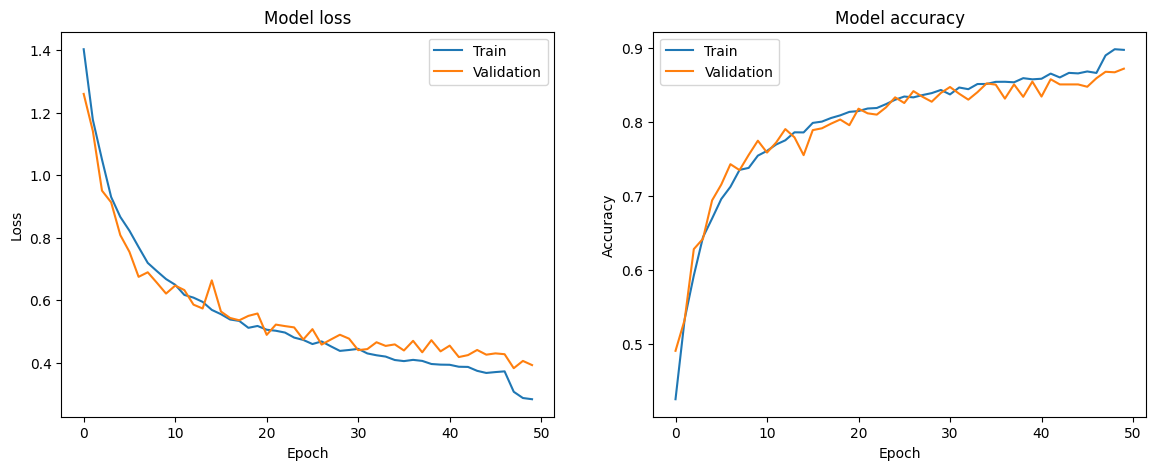

90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 427ms/step
              precision    recall  f1-score   support

        cane       0.83      0.90      0.87       972
     cavallo       0.91      0.83      0.87       524
    farfalla       0.96      0.91      0.93       422
     gallina       0.92      0.90      0.91       619
       gatto       0.81      0.81      0.81       333

    accuracy                           0.88      2870
   macro avg       0.89      0.87      0.88      2870
weighted avg       0.88      0.88      0.88      2870



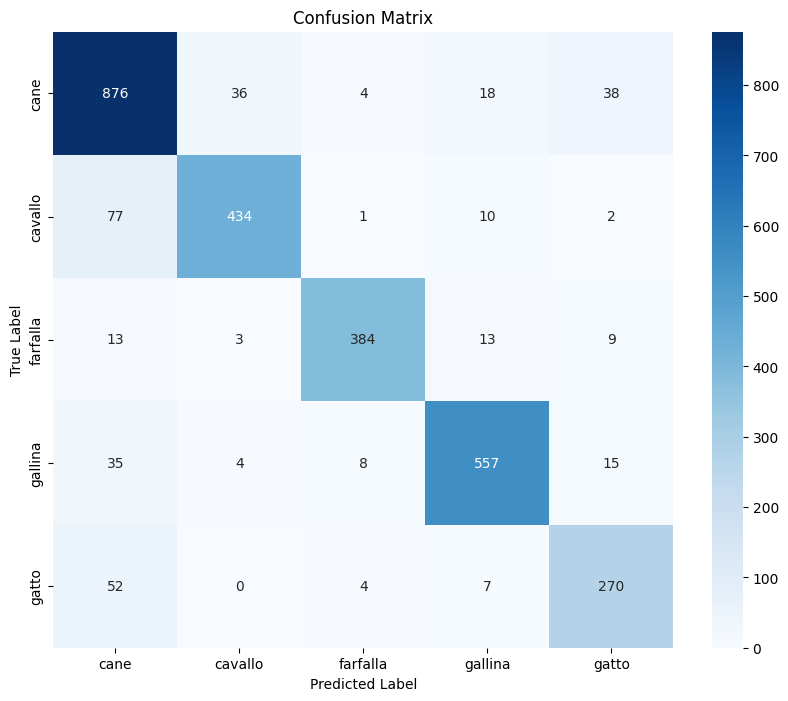

In [7]:
# Plotting losses and accuracies
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation loss values
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Model accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history)

# Evaluating the model
validation_generator.reset()
preds = model.predict(validation_generator)
pred_classes = np.argmax(preds, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, pred_classes, target_names=class_labels)
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, pred_classes)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Build ResNet50V2 Model

This cell defines the `build_resnet50v2` function, which constructs a ResNet50V2 model with pre-trained weights from ImageNet. The model is customized for the specific classification task by adding new layers on top of the pre-trained base model. The steps include:

1. **Import Libraries**:
    - TensorFlow and Keras modules necessary for building and training the model are imported.
    - `ResNet50V2` from `tensorflow.keras.applications` provides the base model with pre-trained weights.

2. **Build ResNet50V2 Function**:
    - The function `build_resnet50v2` takes `img_size` and `num_classes` as parameters:
        - `img_size`: The size to which each input image will be resized.
        - `num_classes`: The number of output classes for the classification task.

3. **Base Model**:
    - The ResNet50V2 model is loaded with pre-trained weights from ImageNet, excluding the top classification layer (`include_top=False`).
    - The input shape is defined as `(img_size, img_size, 3)` to match the dimensions of the input images.

4. **Freezing the Base Model**:
    - All layers in the base model are set to non-trainable by freezing them, preventing their weights from being updated during training.

5. **Adding Custom Layers**:
    - **GlobalAveragePooling2D**: Reduces each feature map to a single value, lowering the dimensionality.
    - **Dense Layer**: Adds a fully connected layer with 512 units and ReLU activation.
    - **Dropout Layer**: Adds a dropout layer with a dropout rate of 0.5 to prevent overfitting.
    - **Predictions Layer**: Adds a fully connected layer with `num_classes` units and softmax activation for multi-class classification.

6. **Compile the Model**:
    - The model is compiled with the categorical cross-entropy loss function and Adam optimizer.
    - Accuracy is used as the evaluation metric.
    - The model summary is printed to provide an overview of the architecture.

The function returns the compiled model, ready for training.


In [8]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_resnet50v2(img_size, num_classes):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    # Freezing the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Adding custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.summary()

    return model

model = build_resnet50v2(img_size, num_classes)

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_pad           │ (None, 230, 230,  │       0 │ input_layer_1[0][0]  │
│ (ZeroPadding2D)     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │   9,472 │ conv1_pad[0][0]      │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pool1_pad           │ (None, 114, 114,  │       0 │ conv1_conv[0][0]     │
│ (ZeroPadding2D)     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ pool1_pool          │ (None, 56, 56,    │       0 │ pool1_pad[0][0]      │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │     256 │ pool1_pool[0][0]     │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │       0 │ conv2_block1_preact… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │   4,096 │ conv2_block1_preact… │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │     256 │ conv2_block1_1_conv… │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │       0 │ conv2_block1_1_bn[0… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │       0 │ conv2_block1_1_relu… │
│ (ZeroPadding2D)     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │  36,864 │ conv2_block1_2_pad[… │
│ (Conv2D)            │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │     256 │ conv2_block1_2_conv… │
│ (BatchNormalizatio… │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │       0 │ conv2_block1_2_bn[0… │
│ (Activation)        │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │  16,640 │ conv2_block1_preact… │
│ (Conv2D)            │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │  16,640 │ conv2_block1_2_relu… │
│ (Conv2D)            │ 256)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │       0 │ conv2_block1_0_conv

 Total params: 24,616,453 (93.90 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

### Train the ResNet50V2 Model

This cell initiates the training process for the ResNet50V2 model using the `fit` method. The training setup includes:

1. **Training Data**:
    - `train_generator`: The data generator for the training dataset, which provides batches of augmented images during training.

2. **Training Parameters**:
    - `epochs`: The number of epochs to train the model, set to 10.

3. **Validation Data**:
    - `validation_generator`: The data generator for the validation dataset, which provides batches of images for evaluating the model's performance during training.

4. **Callbacks**:
    - `checkpoint_resnet50v2`: Saves the best model based on validation performance.
    - `earlystopping`: Stops training early if the validation loss does not improve for 10 consecutive epochs.
    - `learning_rate_reduction`: Reduces the learning rate if the validation loss plateaus for 5 epochs.

The training history, including metrics such as loss and accuracy for both the training and validation sets, is stored in the `history_resnet` variable for further analysis and visualization.


In [9]:
history_resnet = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint_resnet50v2,earlystopping,learning_rate_reduction]
)

Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8967 - loss: 0.3526
Epoch 1: val_loss improved from inf to 0.12099, saving model to resnet50v2.keras
360/360 ━━━━━━━━━━━━━━━━━━━━ 501s 1s/step - accuracy: 0.8968 - loss: 0.3523 - val_accuracy: 0.9589 - val_loss: 0.1210 - learning_rate: 0.0010
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9504 - loss: 0.1489
Epoch 2: val_loss improved from 0.12099 to 0.10209, saving model to resnet50v2.keras
360/360 ━━━━━━━━━━━━━━━━━━━━ 484s 1s/step - accuracy: 0.9504 - loss: 0.1490 - val_accuracy: 0.9638 - val_loss: 0.1021 - learning_rate: 0.0010
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9604 - loss: 0.1200
Epoch 3: val_loss did not improve from 0.10209
360/360 ━━━━━━━━━━━━━━━━━━━━ 481s 1s/step - accuracy: 0.9604 - loss: 0.1201 - val_accuracy: 0.9655 - val_loss: 0.1035 - learning_rate: 0.0010
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9604 - loss: 0.1194
Epoch 4: val_loss did

### Plotting and Evaluating the ResNet50V2 Model

This cell performs the visualization and evaluation of the ResNet50V2 model's performance after training. The steps include:

1. **Plotting Training and Validation Metrics**:
    - The `plot_history_resnet` function creates two subplots:
        - **Loss Plot**: Displays the training and validation loss over the epochs.
        - **Accuracy Plot**: Shows the training and validation accuracy over the epochs.
    - This helps visualize how well the model is learning and if there is any overfitting or underfitting.
    - The function takes `history_resnet` as input, which contains the training history.

2. **Evaluating the Model**:
    - Resets the `validation_generator` to ensure predictions are made on the entire validation set.
    - Uses the trained model to make predictions on the validation set.
    - Converts the predicted probabilities to class labels using `np.argmax`.
    - Retrieves the true class labels from the validation generator.
    - Generates a classification report using `classification_report` from sklearn, which includes precision, recall, and F1-score for each class.

3. **Confusion Matrix**:
    - Computes the confusion matrix using `confusion_matrix` from sklearn, which shows the true vs. predicted labels.
    - Plots a heatmap of the confusion matrix using Seaborn to visualize the model's performance and identify any misclassifications.
    - The heatmap provides a clear picture of how well the model is performing for each class, highlighting areas where it may be making errors.

These steps provide a comprehensive evaluation of the model's performance and help in understanding its strengths and weaknesses.


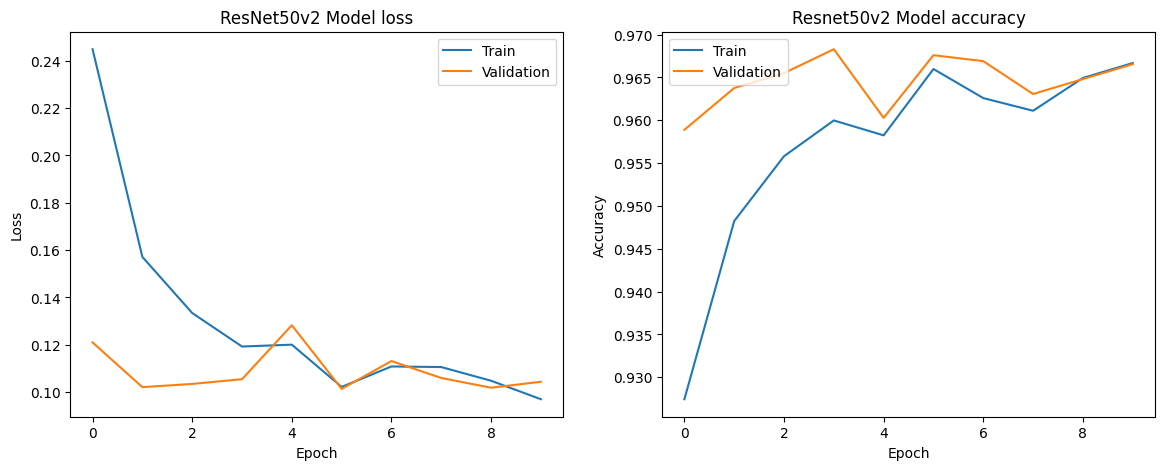

90/90 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step
              precision    recall  f1-score   support

        cane       0.96      0.97      0.96       972
     cavallo       0.97      0.96      0.97       524
    farfalla       1.00      0.98      0.99       422
     gallina       0.98      0.98      0.98       619
       gatto       0.93      0.95      0.94       333

    accuracy                           0.97      2870
   macro avg       0.97      0.97      0.97      2870
weighted avg       0.97      0.97      0.97      2870



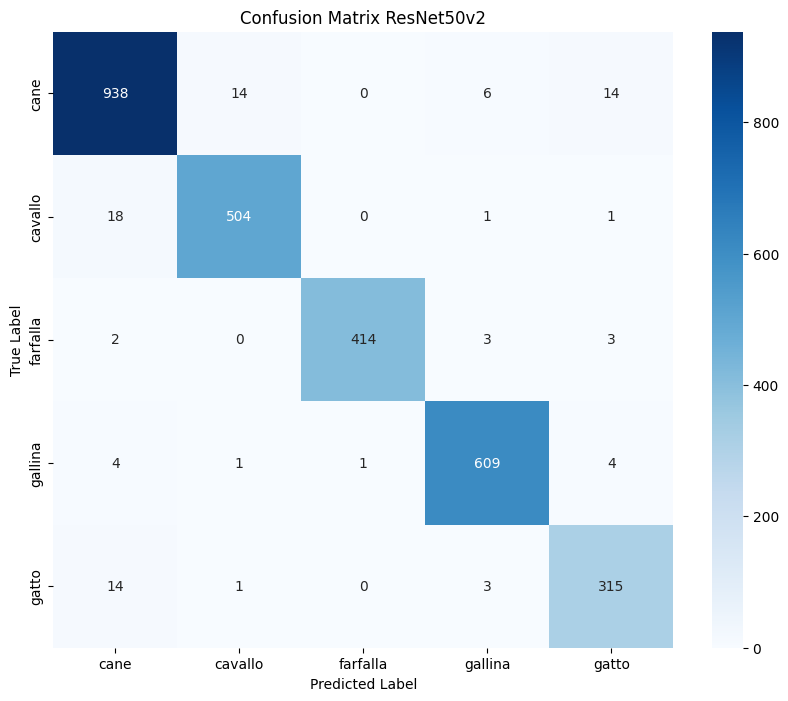

In [10]:
# Plotting losses and accuracies
def plot_history_resnet(history_resnet):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot training & validation loss values
    ax1.plot(history_resnet.history['loss'])
    ax1.plot(history_resnet.history['val_loss'])
    ax1.set_title('ResNet50v2 Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    ax2.plot(history_resnet.history['accuracy'])
    ax2.plot(history_resnet.history['val_accuracy'])
    ax2.set_title('Resnet50v2 Model accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history_resnet(history_resnet)

# Evaluating the model
validation_generator.reset()
preds = model.predict(validation_generator)
pred_classes = np.argmax(preds, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification report
report = classification_report(true_classes, pred_classes, target_names=class_labels)
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, pred_classes)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix ResNet50v2')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()